# Importing Required Libraries

In [2]:
#importing the libralies 
from xgboost import XGBClassifier
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_squared_error
import numpy as np
from pandas import read_csv
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from pymoode.algorithms import DE
from pymoo.optimize import minimize
from pymoo.termination.default import DefaultSingleObjectiveTermination
from scipy import optimize
from scipy.optimize import differential_evolution
from matplotlib import cm
from pyswarms.single.global_best import GlobalBestPSO
from sklearn.metrics import mean_squared_error as MSE
import time

# Importing Covid-19 Data

In [2]:
#importing the data
# This part of the code was adopted from the code by Li et al(2020)
data = pd.read_csv('/home/wisdom/Desktop/project/UsedCombined.txt',sep='\t')
data = data.drop(columns = ['Unnamed: 0'])
removeList = ['Sex','neutrophilCategorical','serumLevelsOfWhiteBloodCellCategorical','lymphocytesCategorical','CTscanResults','XrayResults','Diarrhea','Fever','Coughing','SoreThroat','NauseaVomitting','Fatigue','RenalDisease','diabetes']
for i in removeList:
    data = pd.concat([data,pd.get_dummies(data[i], prefix=i)],axis=1)
data = data.drop(columns=removeList)
data= data.drop(columns = ['Diagnosis'])
data = data.loc[data['Sex_F'] == 1]
X, y = data.iloc[:,1:],data.iloc[:,0]

# Running XGBoost with Default Parameters 

In [3]:
# Splitting the data into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123) # test size equals 20% of data, random state just a random number to ensure reproducibility

In [4]:
#Running the XGBoost Classifier 
XGBCL = XGBClassifier()
classifier1 = XGBCL.fit(X_train,y_train)
preds = classifier1.predict(X_test)

In [5]:
# Printing the confusion matrix
print(classification_report(preds, y_test))
cm = confusion_matrix(preds, y_test)
acc = cm.diagonal().sum()/cm.sum()
print(acc)

              precision    recall  f1-score   support

           0       0.97      0.95      0.96        96
           1       0.87      0.92      0.89        36

    accuracy                           0.94       132
   macro avg       0.92      0.93      0.92       132
weighted avg       0.94      0.94      0.94       132

0.9393939393939394


In [6]:
dtrain = xgb.DMatrix(X_train, label=y_train)
#cv_result = xgb.cv( dtrain, num_boost_round=70, nfold=5)


# Running Bayesian Optimisation on XGBoost

In [7]:
rmse = []
def bo_tune_xgb(max_depth, gamma, n_estimators ,learning_rate):
    clf = xgb.XGBClassifier(learning_rate=learning_rate,
                            max_depth=int(max_depth),
                            n_estimators=int(n_estimators),
                            gamma=gamma)
    
    # Train the classifier on the training data
    clf.fit(X_train, y_train)
    # Predict the model
    pred = clf.predict(X_test)

    # Evaluate the classifier on the validation data
    accuracy = clf.score(X_test, y_test)
    
    # Recording the best accuracy
    acc = accuracy*100
    if len(rmse)==0:
        rmse.append(acc)
    else:
        if max(rmse)< acc:
            rmse.append(acc)
        else:
            rmse.append(max(rmse))
        
    return accuracy

In [8]:

dtrain = xgb.DMatrix(X_train, label=y_train)

#Bayesian Optimization function for xgboost
#specify the parameters you want to tune as keyword arguments
start =time.time()

#Invoking the Bayesian Optimizer with the specified parameters to tune
xgb_bo = BayesianOptimization(bo_tune_xgb, {'max_depth': (1, 20),
                                             'gamma': (0, 1),
                                             'learning_rate':(0,1),
                                             'n_estimators':(10,200)})

#performing Bayesian optimization for 100 iterations with 8 steps of random exploration with an #acquisition function of expected improvement
xgb_bo.maximize(n_iter=100, init_points=10, acq='ei')
end = time.time()

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... |
-------------------------------------------------------------------------
| 1         | 0.9394    | 0.208     | 0.6047    | 12.92     | 184.1     |


<ipython-input-8-439861fa54c0>:14: DeprecationWarning: 
Passing acquisition function parameters or gaussian process parameters to maximize
is no longer supported, and will cause an error in future releases. Instead,
please use the "set_gp_params" method to set the gp params, and pass an instance
 of bayes_opt.util.UtilityFunction using the acquisition_function argument

  xgb_bo.maximize(n_iter=100, init_points=10, acq='ei')


| 2         | 0.9242    | 0.3271    | 0.3763    | 14.03     | 144.9     |
| 3         | 0.9242    | 0.414     | 0.5807    | 12.92     | 28.45     |
| 4         | 0.9015    | 0.01851   | 0.4952    | 1.277     | 130.6     |
| 5         | 0.9318    | 0.816     | 0.2856    | 15.28     | 18.99     |
| 6         | 0.9394    | 0.2791    | 0.8692    | 15.9      | 187.7     |
| 7         | 0.9242    | 0.6479    | 0.05728   | 12.03     | 66.91     |
| 8         | 0.9394    | 0.5434    | 0.7796    | 15.27     | 56.33     |
| 9         | 0.9318    | 0.394     | 0.473     | 4.692     | 181.1     |
| 10        | 0.9545    | 0.4461    | 0.7009    | 5.945     | 42.32     |
| 11        | 0.9091    | 0.0       | 1.0       | 1.0       | 49.54     |
| 12        | 0.9394    | 0.7312    | 0.3991    | 8.672     | 42.2      |
| 13        | 0.9394    | 0.1031    | 0.9526    | 4.845     | 40.09     |
| 14        | 0.7121    | 1.0       | 0.0       | 5.294     | 44.21     |
| 15        | 0.9318    | 0.881     | 

| 70        | 0.9318    | 0.01441   | 0.03115   | 13.26     | 185.4     |
| 71        | 0.9394    | 0.1934    | 0.8061    | 14.43     | 58.02     |
| 72        | 0.9091    | 0.99      | 0.2161    | 9.917     | 187.7     |
| 73        | 0.9242    | 0.8526    | 0.1992    | 17.66     | 185.5     |
| 74        | 0.9394    | 0.06829   | 0.9433    | 13.08     | 54.04     |
| 75        | 0.9091    | 0.08384   | 0.9898    | 8.625     | 42.68     |
| 76        | 0.9242    | 0.9035    | 0.8289    | 5.302     | 42.14     |
| 77        | 0.9394    | 0.1672    | 0.9245    | 14.25     | 53.81     |
| 78        | 0.9242    | 0.4689    | 0.1681    | 13.5      | 53.56     |
| 79        | 0.9242    | 0.027     | 0.9819    | 6.411     | 42.29     |
| 80        | 0.9318    | 0.8002    | 0.1019    | 6.178     | 42.24     |
| 81        | 0.9242    | 0.8587    | 0.7784    | 16.42     | 56.37     |
| 82        | 0.9167    | 0.9671    | 0.01889   | 19.41     | 186.5     |
| 83        | 0.9545    | 0.003144  | 

In [9]:
#Checking the time ellapsed 
print("Total time ellapsed is:", end-start)

Total time ellapsed is: 27.963754892349243


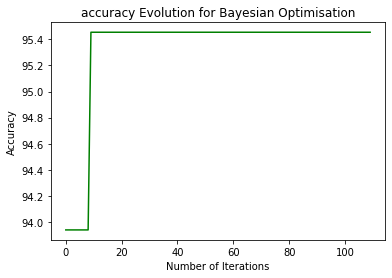

In [10]:
#Checking the evolution of the cost

import matplotlib as plt
# Initialising x and y for plotting
x = np.arange(0,len(rmse))
y = rmse
# plotting
pyplot.title("accuracy Evolution for Bayesian Optimisation")
pyplot.xlabel("Number of Iterations")
pyplot.ylabel("Accuracy")
pyplot.plot(x, y, color ="green")
#pyplot.savefig("bayesplot.jpg")
pyplot.show()


In [11]:
# Running the XGBoost with the optimiside hyperparameters by Bayesian optimisation
#Extracting the best parameters
params = xgb_bo.max
params = params['params']
print(params)
#Converting the max_depth and n_estimator values from float to int
params['max_depth']= int(params['max_depth'])
params['n_estimators']= int(params['n_estimators'])

#train using best parameters
classifier2 = XGBClassifier(**params).fit(X_train,y_train)
preds2 = classifier2.predict(X_test)

{'gamma': 0.44614564499244547, 'learning_rate': 0.700868220756551, 'max_depth': 5.945310262789979, 'n_estimators': 42.32017682041174}


In [12]:
# printing the confusion matrix of the bayesian optimised hyperparameters 
#Accuracy obtained on the training set
print(classification_report(preds2, y_test))
cm = confusion_matrix(preds2, y_test)
acc = cm.diagonal().sum()/cm.sum()
print(acc)
print(cm)

              precision    recall  f1-score   support

           0       0.98      0.96      0.97        96
           1       0.89      0.94      0.92        36

    accuracy                           0.95       132
   macro avg       0.94      0.95      0.94       132
weighted avg       0.96      0.95      0.95       132

0.9545454545454546
[[92  4]
 [ 2 34]]


# Running the Differential Evolution

In [13]:
rmse1=[]
#dtrain = xgb.DMatrix(X_train, y_train)
def xgb2( w):
    w[2] = round(w[2])
    params = {
          'max_depth': int(w[2]), # 0,
          'gamma': w[0] , # 0.01
          'n_estimators': int(w[3]),
          'learning_rate': w[1]}
    
    dtrain = xgb.DMatrix(X_train, y_train)
    dvalid = xgb.DMatrix(X_test, y_test)
    
    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
    
    model = xgb.train(params, dtrain, 100, watchlist, maximize=True, early_stopping_rounds = 25, verbose_eval=0)
    
    # make predictions for test data
    X_valid = xgb.DMatrix(X_test)
    y_pred = model.predict(X_valid, ntree_limit=model.best_ntree_limit)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, predictions)
    
    # Recording tthe accuracy
    acc = accuracy*100
    if len(rmse1)==0:
        rmse1.append(acc)
    else:
        if max(rmse1)< acc:
            rmse1.append(acc)
        else:
            rmse1.append(max(rmse1))
    return model, accuracy

In [14]:
#Define an objective funtion.
def Objective_Function2(w):
    #w = w.tolist()
    model, accuracy = xgb2(w)
    return -1*accuracy

In [15]:
start = time.time()
result = differential_evolution(Objective_Function2,
                 [(0,1), # gamma
                  (0,1), # learning_rate 
                  (1,10), # max_depth
                  (10,200)], # n_estimators 
                args=(), strategy='best1bin', maxiter=100, popsize=10, tol=0.001, mutation=(0.5, 1), 
                recombination=0.7, seed=None, callback=None, disp=False, polish=True, 
                init='latinhypercube', atol=0, updating='immediate', workers=1, constraints=(), x0=None, integrality=None, vectorized=False)
end =time.time()

[12:36:21] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:21] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:21] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:21] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.


/home/wisdom/.local/lib/python3.9/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/home/wisdom/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[12:36:21] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:21] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:21] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:21] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:21] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:21] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:21] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:21] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:21] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:22] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:22] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:22

[12:36:25] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:25] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:25] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:25] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:25] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:25] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:25] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:25] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:25] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:25] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:26] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:26]

[12:36:29] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:29] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:29] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:29] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:29] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:29] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:29] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:29] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:29] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:29] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:30] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:30]

[12:36:33] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:33] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:34] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:34] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:34] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:34] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:34] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:34] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:34] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:34] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:34] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:34]

[12:36:37] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:37] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:38] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:38] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:38] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:38] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:38] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:38] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:38] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:38] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:38] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:38]

[12:36:42] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:42] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:42] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:42] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:42] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:42] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:42] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:42] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:42] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:42] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:42] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:42]

[12:36:46] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:46] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:46] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:46] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:46] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:46] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:47] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:47] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:47] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:47] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:47] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:47]

[12:36:51] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:51] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:51] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:51] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:52] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:52] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:52] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:52] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:52] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:52] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:52] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:52]

[12:36:56] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:56] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:56] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:56] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:56] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:56] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:56] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:57] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:57] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:57] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:57] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:36:57]

[12:37:01] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:01] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:01] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:01] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:01] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:02] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:02] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:02] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:02] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:02] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:02] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:02]

[12:37:06] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:06] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:06] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:06] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:07] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:07] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:07] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:07] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:07] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:07] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:07] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:07]

[12:37:12] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:12] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:12] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:12] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:12] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:12] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:12] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:12] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:12] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:12] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:12] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:12]

[12:37:17] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:17] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:17] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:17] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:17] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:17] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:17] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:17] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:17] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:17] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:17] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:17]

[12:37:23] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:23] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:23] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:23] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:23] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:23] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:23] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:23] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:23] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:23] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:23] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:23]

[12:37:27] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:27] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:28] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:28] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:28] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:28] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:28] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:28] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:28] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:28] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:28] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:28]

[12:37:32] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:32] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:32] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:32] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:32] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:32] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:32] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:32] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:32] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:32] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:32] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:32]

[12:37:37] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:37] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:37] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:37] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:37] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:37] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:37] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:37] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:37] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:37] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:37] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:37]

[12:37:41] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:41] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:41] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:41] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:41] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:41] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:41] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:42] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:42] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:42] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:42] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:42]

[12:37:46] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:46] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:46] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:46] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:46] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:46] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:46] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:46] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:46] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:46] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:46] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:37:46]

In [16]:
print("Total time elapsed is : ", end-start)

Total time elapsed is :  88.39269804954529


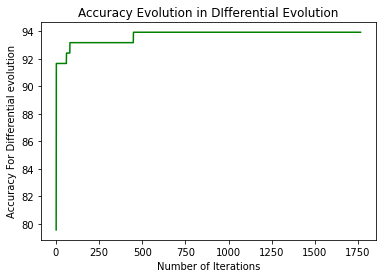

In [17]:
# Checkingn the cost of the differential evolution
x = np.arange(1,len(rmse1)+1)
y = rmse1
 
# plotting
pyplot.title("Accuracy Evolution in DIfferential Evolution")
pyplot.xlabel("Number of Iterations")
pyplot.ylabel("Accuracy For Differential evolution")
pyplot.plot(x, y, color ="green")
#pyplot.xlim(None,100)
#pyplot.savefig("DEplot.jpg")
pyplot.show()

In [18]:
# running the XGBoost using the differential evolution optimised hyperparameters 

best_parameters = result.x
best_parameters 

array([  0.37949157,   0.86953786,   7.70604816, 157.00582678])

In [19]:
params1 = {'max_depth': int(best_parameters[2]),
              'gamma': best_parameters[0],
              'n_estimators': int(best_parameters[3]),
              'learning_rate':best_parameters[1]}


classifier3 = XGBClassifier(**params1).fit(X_train,y_train)
preds3 = classifier3.predict(X_test)

In [20]:
#printing the confusion matrix for differential evolution optimised hyperparameters 
print(classification_report(preds3, y_test))
cm = confusion_matrix(preds3, y_test)
acc = cm.diagonal().sum()/cm.sum()
#print(acc)
print(cm)

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        94
           1       0.87      0.87      0.87        38

    accuracy                           0.92       132
   macro avg       0.91      0.91      0.91       132
weighted avg       0.92      0.92      0.92       132

[[89  5]
 [ 5 33]]


# Running Particle Swam Optimisation 

In [45]:
# Define the fitness function for PSO
rmse2 = []
def fitness_function(params):
    # Unpack the particle's position into XGBoost hyperparameters
    learning_rate = params[0,0]
    max_depth = params[0,1]
    n_estimators = params[0,2]
    gamma = params[0,3]
   
    # Create an XGBoost classifier with the current hyperparameter settings
    clf = xgb.XGBClassifier(learning_rate=learning_rate,
                            max_depth=int(max_depth),
                            n_estimators=int(n_estimators),
                            gamma=gamma)
    
    # Train the classifier on the training data
    clf.fit(X_train, y_train)
    # Predict the model
    pred = clf.predict(X_test)

    # Evaluate the classifier on the validation data
    accuracy = clf.score(X_test, y_test)
    
    # Recording the accuracy
    acc = accuracy*100
    if len(rmse2)==0:
        rmse2.append(acc)
    else:
        if max(rmse2)< acc:
            rmse2.append(acc)
        else:
            rmse2.append(max(rmse2))
    return 1-accuracy

In [46]:
start = time.time()
best=[]
# Define the bounds for the hyperparameters
lower_bound = np.array([0.01,1,10,0])
upper_bound = np.array([1, 10,200,1])
bounds = (lower_bound, upper_bound)
# Initialize the Particle Swarm Optimization algorithm
optimizer = GlobalBestPSO(n_particles=10, dimensions=4, bounds=bounds, options={'c1': 0.5, 'c2': 0.3, 'w': 0.9})

# Run the optimization
best_cost, best_params = optimizer.optimize(fitness_function, iters=100)
end =time.time()

2023-05-21 12:43:07,201 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.0379
2023-05-21 12:43:12,127 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.037878787878787845, best pos: [ 0.38927934  6.62860315 60.11224718  0.80082593]


In [47]:
print("Total time elapsed is : ", end-start)

Total time elapsed is :  4.946355581283569


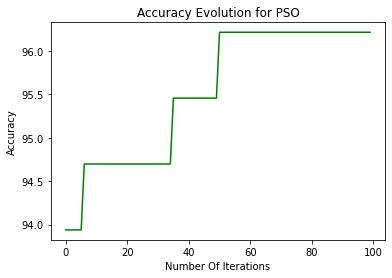

In [48]:
# Checkingn the cost of the differential evolution
x = np.arange(0,len(rmse2))
y = rmse2
 
# plotting
pyplot.title("Accuracy Evolution for PSO")
pyplot.xlabel("Number Of Iterations")
pyplot.ylabel("Accuracy")
pyplot.plot(x, y, color ="green")
#pyplot.savefig("PSOplot.jpg")
pyplot.show()

In [49]:
#Running XGBoost using PSO optimised hyperparmeters 
best_learning_rate = best_params[0]
best_max_depth = best_params[1]
best_n_estimators = best_params[2]
best_gamma = best_params[3]

# Create the final XGBoost classifier with the best hyperparameter settings
classifier4 = xgb.XGBClassifier(learning_rate=best_learning_rate,
                             max_depth=int(best_max_depth),
                             n_estimators=int(best_n_estimators),
                             gamma=best_gamma)

# Train the final classifier on the entire dataset
classifier4.fit(X_train, y_train)

preds4 = classifier4.predict(X_test)
#printing the confusion matrix for PSO optimised hyperparmaters 
print(classification_report(preds4, y_test))
cm = confusion_matrix(preds4, y_test)
acc = cm.diagonal().sum()/cm.sum()
#print(acc)
print(cm)

              precision    recall  f1-score   support

           0       0.99      0.96      0.97        97
           1       0.89      0.97      0.93        35

    accuracy                           0.96       132
   macro avg       0.94      0.97      0.95       132
weighted avg       0.96      0.96      0.96       132

[[93  4]
 [ 1 34]]


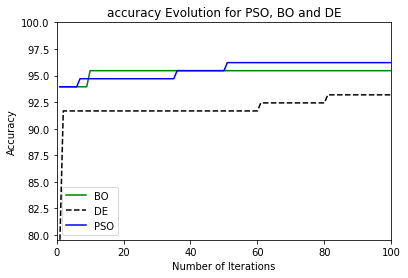

In [50]:
x1 = np.arange(1,len(rmse)+1)
y1 = rmse
x2 = np.arange(1,len(rmse1)+1)
y2 = rmse1
x3 = np.arange(1,len(rmse2)+1)
y3 = rmse2
# plotting
pyplot.title("accuracy Evolution for PSO, BO and DE")
pyplot.xlabel('Number of Iterations')
pyplot.ylabel("Accuracy")
pyplot.plot(x1, y1, color ="green", label='BO')
pyplot.plot(x2, y2, color ="black", linestyle = 'dashed' ,label='DE')
pyplot.plot(x3, y3, color ="blue", label='PSO')
pyplot.xlim(0,100)
pyplot.ylim(min(min(rmse), min(rmse1), min(rmse2)), 100)
pyplot.legend()
#pyplot.savefig("Combinedplot.jpg")
pyplot.show()

# Computing the performance of the three optimisation algorithms and Record Their Performance 


In [51]:
# Function for calculating the evaluation metrics(accuracy, precision, recall, F1-score) values 
def eval_metrics(cm, print_res = 0):
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    accuracy = (tp+tn)/ (tp+fn+fp+tn)
    f1_score = (2*precision*recall)/(precision+recall)
    if print_res == 1:
        print('Precision =     {:.3f}'.format(tp/(tp+fp)))
        print('Recall (TPR) =  {:.3f}'.format(tp/(tp+fn)))
        print('Fallout (FPR) = {:.3e}'.format(fp/(fp+tn)))
    return precision, recall, accuracy, f1_score

## Performance Results for Bayesian Optimisation 


In [52]:
dtrain = xgb.DMatrix(X_train, label=y_train)

In [53]:
accuracy1 = []
precision1 = []
recall1 = []
f1_score1 =[]; gamma1 =[]; max_depth1=[]; learning_rate1 = []; n_estimators1 = []
for i in range(8):
    xgb_bo = BayesianOptimization(bo_tune_xgb, {'max_depth': (1, 10),
                                             'gamma': (0, 1),
                                             'learning_rate':(0,1),
                                             'n_estimators':(10,200)})
    xgb_bo.maximize(n_iter=100, init_points=8, acq='ei')
    params = xgb_bo.max
    params = params['params']
    #print(params)
    #Converting the max_depth and n_estimator values from float to int
    params['max_depth']= int(params['max_depth'])
    params['n_estimators']= int(params['n_estimators'])
    gamma1.append(params['gamma']); max_depth1.append(params['max_depth'])
    learning_rate1.append(params['learning_rate']); n_estimators1.append(params['n_estimators'])

    #train using best parameters
    classifier2 = XGBClassifier(**params).fit(X_train,y_train)
    preds2 = classifier2.predict(X_test)
    cm = confusion_matrix(preds2, y_test)
    prec, recal, acc, f1_score = eval_metrics(cm)
    accuracy1.append(acc); precision1.append(prec); recall1.append(recal), f1_score1.append(f1_score)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... |
-------------------------------------------------------------------------
| 1         | 0.8788    | 0.2786    | 0.1535    | 1.57      | 145.2     |
| 2         | 0.947     | 0.4764    | 0.7332    | 9.392     | 52.95     |
| 3         | 0.9318    | 0.4128    | 0.3394    | 4.008     | 84.54     |
| 4         | 0.9167    | 0.2903    | 0.9176    | 3.366     | 82.41     |
| 5         | 0.9015    | 0.7939    | 0.6918    | 1.946     | 71.91     |


<ipython-input-53-80b5a0c8e422>:10: DeprecationWarning: 
Passing acquisition function parameters or gaussian process parameters to maximize
is no longer supported, and will cause an error in future releases. Instead,
please use the "set_gp_params" method to set the gp params, and pass an instance
 of bayes_opt.util.UtilityFunction using the acquisition_function argument

  xgb_bo.maximize(n_iter=100, init_points=8, acq='ei')


| 6         | 0.9015    | 0.7742    | 0.4857    | 1.997     | 137.1     |
| 7         | 0.9242    | 0.3546    | 0.8973    | 7.259     | 38.11     |
| 8         | 0.9318    | 0.6279    | 0.8597    | 9.751     | 146.5     |
| 9         | 0.9167    | 0.871     | 0.8824    | 8.848     | 49.82     |
| 10        | 0.9318    | 0.6005    | 0.24      | 9.38      | 54.2      |
| 11        | 0.9394    | 0.1148    | 0.1383    | 7.903     | 52.47     |
| 12        | 0.7121    | 0.5979    | 0.0       | 4.795     | 87.61     |
| 13        | 0.947     | 1.0       | 1.0       | 6.423     | 54.45     |
| 14        | 0.9394    | 0.7761    | 0.1568    | 4.52      | 52.59     |
| 15        | 0.7121    | 0.0       | 0.0       | 4.114     | 55.64     |
| 16        | 0.9394    | 0.3054    | 0.9943    | 6.37      | 51.89     |
| 17        | 0.9167    | 0.6796    | 0.9028    | 4.341     | 50.37     |
| 18        | 0.7121    | 0.4009    | 0.0       | 6.192     | 82.66     |
| 19        | 0.9015    | 0.979     | 

| 74        | 0.9394    | 0.2079    | 0.7987    | 5.139     | 157.9     |
| 75        | 0.9394    | 0.0006805 | 0.03296   | 5.948     | 159.9     |
| 76        | 0.9167    | 0.0       | 1.0       | 3.726     | 159.9     |
| 77        | 0.9167    | 0.2594    | 0.9406    | 8.368     | 160.3     |
| 78        | 0.947     | 0.8994    | 0.5876    | 5.406     | 162.3     |
| 79        | 0.9167    | 0.0003532 | 0.7085    | 7.38      | 163.4     |
| 80        | 0.8712    | 0.1294    | 0.01998   | 3.739     | 163.7     |
| 81        | 0.9394    | 0.9361    | 0.5505    | 6.801     | 161.3     |
| 82        | 0.7121    | 1.0       | 0.0       | 10.0      | 162.6     |
| 83        | 0.947     | 0.2497    | 0.6544    | 2.169     | 132.7     |
| 84        | 0.9318    | 0.1465    | 0.8588    | 4.429     | 133.3     |
| 85        | 0.9091    | 0.2554    | 0.8833    | 3.675     | 130.8     |
| 86        | 0.9091    | 0.2788    | 0.1014    | 2.503     | 134.8     |
| 87        | 0.8939    | 0.9802    | 

<ipython-input-53-80b5a0c8e422>:10: DeprecationWarning: 
Passing acquisition function parameters or gaussian process parameters to maximize
is no longer supported, and will cause an error in future releases. Instead,
please use the "set_gp_params" method to set the gp params, and pass an instance
 of bayes_opt.util.UtilityFunction using the acquisition_function argument

  xgb_bo.maximize(n_iter=100, init_points=8, acq='ei')


| 2         | 0.9167    | 0.7346    | 0.886     | 2.944     | 166.9     |
| 3         | 0.8636    | 0.8117    | 0.08349   | 1.213     | 146.6     |
| 4         | 0.9394    | 0.1259    | 0.8318    | 9.772     | 27.12     |
| 5         | 0.9242    | 0.4034    | 0.7793    | 4.0       | 141.3     |
| 6         | 0.9015    | 0.5919    | 0.7292    | 3.893     | 171.9     |
| 7         | 0.9318    | 0.4695    | 0.1388    | 4.06      | 53.29     |
| 8         | 0.8788    | 0.9657    | 0.4982    | 1.19      | 161.6     |
| 9         | 0.9394    | 0.1374    | 0.7288    | 6.231     | 157.6     |
| 10        | 0.947     | 0.4751    | 0.4062    | 6.553     | 50.67     |
| 11        | 0.9621    | 0.3618    | 0.6106    | 7.516     | 52.96     |
| 12        | 0.7121    | 1.0       | 0.0       | 10.0      | 51.99     |
| 13        | 0.9242    | 0.07725   | 0.9839    | 7.587     | 53.26     |
| 14        | 0.947     | 0.4831    | 0.4008    | 6.805     | 52.1      |
| 15        | 0.7121    | 1.0       | 

| 69        | 0.9394    | 1.0       | 0.8927    | 6.468     | 146.7     |
| 70        | 0.9545    | 0.05154   | 0.7151    | 7.404     | 147.3     |
| 71        | 0.9545    | 0.3077    | 0.4155    | 5.945     | 147.3     |
| 72        | 0.9394    | 0.3119    | 0.913     | 8.037     | 148.3     |
| 73        | 0.9394    | 0.7122    | 0.4379    | 5.103     | 147.2     |
| 74        | 0.9167    | 0.4453    | 0.1114    | 3.641     | 188.8     |
| 75        | 0.9394    | 0.1303    | 0.7677    | 7.221     | 148.4     |
| 76        | 0.9394    | 0.7868    | 0.3915    | 5.873     | 36.63     |
| 77        | 0.8939    | 0.1254    | 0.009153  | 6.75      | 146.3     |
| 78        | 0.9394    | 0.5171    | 0.8954    | 5.362     | 47.55     |
| 79        | 0.947     | 0.05634   | 0.7511    | 8.283     | 147.7     |
| 80        | 0.947     | 0.04994   | 0.1589    | 5.604     | 49.58     |
| 81        | 0.9318    | 0.7385    | 0.7605    | 7.593     | 183.2     |
| 82        | 0.9394    | 0.1124    | 

<ipython-input-53-80b5a0c8e422>:10: DeprecationWarning: 
Passing acquisition function parameters or gaussian process parameters to maximize
is no longer supported, and will cause an error in future releases. Instead,
please use the "set_gp_params" method to set the gp params, and pass an instance
 of bayes_opt.util.UtilityFunction using the acquisition_function argument

  xgb_bo.maximize(n_iter=100, init_points=8, acq='ei')


| 4         | 0.9242    | 0.9143    | 0.9366    | 8.975     | 145.7     |
| 5         | 0.9318    | 0.5036    | 0.1027    | 5.602     | 51.61     |
| 6         | 0.9091    | 0.9822    | 0.1703    | 3.616     | 96.46     |
| 7         | 0.9394    | 0.5179    | 0.6741    | 5.329     | 120.9     |
| 8         | 0.9015    | 0.7514    | 0.6424    | 2.241     | 22.82     |
| 9         | 0.9242    | 0.6351    | 0.1668    | 7.813     | 91.0      |
| 10        | 0.947     | 0.6082    | 0.6958    | 5.432     | 121.0     |
| 11        | 0.9318    | 0.739     | 0.7699    | 5.477     | 122.1     |
| 12        | 0.9394    | 1.0       | 0.7648    | 6.069     | 121.1     |
| 13        | 0.9318    | 0.05598   | 0.4638    | 5.809     | 121.3     |
| 14        | 0.9394    | 0.9395    | 0.1671    | 4.951     | 121.2     |
| 15        | 0.9242    | 0.0       | 0.8859    | 9.44      | 60.55     |
| 16        | 0.9167    | 0.8608    | 0.4511    | 9.247     | 58.53     |
| 17        | 0.9242    | 0.8951    | 

| 72        | 0.9621    | 0.4824    | 0.982     | 5.997     | 131.0     |
| 73        | 0.9318    | 0.7212    | 0.8095    | 6.06      | 130.8     |
| 74        | 0.9015    | 0.3984    | 0.7545    | 2.14      | 176.6     |
| 75        | 0.9394    | 0.1621    | 0.6       | 5.999     | 131.1     |
| 76        | 0.9394    | 0.4928    | 0.8576    | 4.845     | 182.1     |
| 77        | 0.947     | 0.1285    | 0.8957    | 5.681     | 130.7     |
| 78        | 0.9318    | 0.8242    | 0.3039    | 6.011     | 120.7     |
| 79        | 0.947     | 0.6746    | 0.1597    | 4.952     | 183.4     |
| 80        | 0.9394    | 0.2512    | 1.0       | 6.018     | 130.9     |
| 81        | 0.9545    | 0.2003    | 0.6372    | 6.311     | 130.7     |
| 82        | 0.947     | 0.2954    | 0.3815    | 7.028     | 151.0     |
| 83        | 0.9242    | 0.2802    | 0.6441    | 2.813     | 114.3     |
| 84        | 0.9545    | 0.106     | 0.3497    | 6.324     | 150.6     |
| 85        | 0.9394    | 0.04443   | 

<ipython-input-53-80b5a0c8e422>:10: DeprecationWarning: 
Passing acquisition function parameters or gaussian process parameters to maximize
is no longer supported, and will cause an error in future releases. Instead,
please use the "set_gp_params" method to set the gp params, and pass an instance
 of bayes_opt.util.UtilityFunction using the acquisition_function argument

  xgb_bo.maximize(n_iter=100, init_points=8, acq='ei')


| 1         | 0.9242    | 0.0147    | 0.02053   | 7.298     | 177.3     |
| 2         | 0.8939    | 0.08443   | 0.6996    | 1.558     | 32.73     |
| 3         | 0.9318    | 0.4262    | 0.5843    | 4.625     | 133.6     |
| 4         | 0.9242    | 0.2392    | 0.6866    | 2.194     | 173.3     |
| 5         | 0.9318    | 0.4602    | 0.7423    | 4.65      | 192.5     |
| 6         | 0.9091    | 0.8089    | 0.1167    | 8.817     | 166.4     |
| 7         | 0.8864    | 0.6641    | 0.6147    | 1.254     | 38.47     |
| 8         | 0.9318    | 0.06773   | 0.1119    | 3.801     | 152.6     |
| 9         | 0.9015    | 0.8883    | 0.802     | 1.0       | 108.9     |
| 10        | 0.947     | 0.1523    | 0.6918    | 9.933     | 143.2     |
| 11        | 0.7121    | 0.0       | 0.0       | 10.0      | 77.27     |
| 12        | 0.7121    | 1.0       | 0.0       | 10.0      | 10.0      |
| 13        | 0.9242    | 0.0       | 1.0       | 10.0      | 120.4     |
| 14        | 0.7121    | 0.0       | 

| 69        | 0.9394    | 0.04919   | 0.2537    | 8.942     | 184.7     |
| 70        | 0.947     | 0.09542   | 0.3074    | 9.844     | 55.03     |
| 71        | 0.7121    | 0.0       | 0.0       | 5.305     | 40.66     |
| 72        | 0.9015    | 0.872     | 0.5534    | 9.489     | 41.52     |
| 73        | 0.9318    | 0.0       | 1.0       | 8.845     | 109.2     |
| 74        | 0.9167    | 0.902     | 0.9658    | 8.007     | 53.72     |
| 75        | 0.9394    | 0.7073    | 0.1094    | 4.84      | 171.7     |
| 76        | 0.947     | 1.0       | 1.0       | 6.96      | 174.3     |
| 77        | 0.9167    | 0.3062    | 0.2877    | 9.721     | 174.4     |
| 78        | 0.9242    | 0.05165   | 0.8552    | 4.149     | 111.3     |
| 79        | 0.8636    | 0.0       | 0.002841  | 5.707     | 46.92     |
| 80        | 0.9394    | 0.8587    | 0.3498    | 6.222     | 168.8     |
| 81        | 0.9167    | 0.6846    | 0.04385   | 7.585     | 191.8     |
| 82        | 0.9242    | 0.0       | 

<ipython-input-53-80b5a0c8e422>:10: DeprecationWarning: 
Passing acquisition function parameters or gaussian process parameters to maximize
is no longer supported, and will cause an error in future releases. Instead,
please use the "set_gp_params" method to set the gp params, and pass an instance
 of bayes_opt.util.UtilityFunction using the acquisition_function argument

  xgb_bo.maximize(n_iter=100, init_points=8, acq='ei')


| 3         | 0.8258    | 0.3203    | 0.04032   | 3.782     | 21.59     |
| 4         | 0.9167    | 0.1555    | 0.6486    | 3.668     | 76.09     |
| 5         | 0.9318    | 0.9669    | 0.4475    | 4.229     | 25.37     |
| 6         | 0.8636    | 0.7348    | 0.1354    | 1.856     | 96.34     |
| 7         | 0.8106    | 0.711     | 0.1007    | 1.148     | 41.32     |
| 8         | 0.9242    | 0.7677    | 0.6222    | 7.865     | 154.1     |
| 9         | 0.947     | 0.4732    | 0.2766    | 7.014     | 94.12     |
| 10        | 0.9318    | 0.2782    | 0.2108    | 3.275     | 168.0     |
| 11        | 0.9167    | 0.8405    | 0.1013    | 8.239     | 49.08     |
| 12        | 0.9621    | 0.365     | 0.4865    | 5.656     | 47.57     |
| 13        | 0.9394    | 0.2446    | 1.0       | 3.364     | 165.7     |
| 14        | 0.947     | 0.03191   | 0.2885    | 5.212     | 49.94     |
| 15        | 0.9318    | 0.05267   | 0.1073    | 7.38      | 45.83     |
| 16        | 0.9545    | 0.9457    | 

| 71        | 0.9015    | 0.2131    | 0.03762   | 5.641     | 40.38     |
| 72        | 0.9318    | 0.07758   | 1.0       | 4.393     | 167.1     |
| 73        | 0.9015    | 0.2295    | 0.05125   | 6.406     | 49.75     |
| 74        | 0.9545    | 0.06624   | 0.3366    | 5.258     | 51.09     |
| 75        | 0.9242    | 0.5651    | 0.07642   | 6.665     | 46.84     |
| 76        | 0.9394    | 1.0       | 0.214     | 6.017     | 166.2     |
| 77        | 0.947     | 0.08132   | 0.2392    | 9.011     | 162.8     |
| 78        | 0.9167    | 0.8376    | 0.07546   | 8.814     | 161.5     |
| 79        | 0.9318    | 0.0       | 1.0       | 8.202     | 93.82     |
| 80        | 0.947     | 0.08367   | 0.1424    | 5.956     | 158.8     |
| 81        | 0.7121    | 1.0       | 0.0       | 6.289     | 24.54     |
| 82        | 0.9242    | 0.0       | 1.0       | 7.244     | 23.14     |
| 83        | 0.9167    | 0.9707    | 0.815     | 4.497     | 168.0     |
| 84        | 0.9318    | 0.9302    | 

<ipython-input-53-80b5a0c8e422>:10: DeprecationWarning: 
Passing acquisition function parameters or gaussian process parameters to maximize
is no longer supported, and will cause an error in future releases. Instead,
please use the "set_gp_params" method to set the gp params, and pass an instance
 of bayes_opt.util.UtilityFunction using the acquisition_function argument

  xgb_bo.maximize(n_iter=100, init_points=8, acq='ei')


| 2         | 0.9242    | 0.8446    | 0.553     | 9.494     | 145.8     |
| 3         | 0.9394    | 0.3154    | 0.6213    | 8.8       | 182.1     |
| 4         | 0.9318    | 0.2988    | 0.286     | 3.265     | 55.69     |
| 5         | 0.9394    | 0.1467    | 0.5257    | 8.864     | 132.7     |
| 6         | 0.9545    | 0.525     | 0.5009    | 5.427     | 14.57     |
| 7         | 0.9091    | 0.0379    | 0.9633    | 1.291     | 62.88     |
| 8         | 0.947     | 0.2027    | 0.8145    | 6.05      | 126.7     |
| 9         | 0.9318    | 0.4096    | 0.4958    | 6.933     | 19.35     |
| 10        | 0.9394    | 0.9916    | 0.3653    | 6.651     | 98.19     |
| 11        | 0.9242    | 0.4851    | 0.7506    | 3.787     | 61.17     |
| 12        | 0.9167    | 0.793     | 0.3998    | 5.009     | 12.12     |
| 13        | 0.9394    | 0.8046    | 0.6721    | 6.936     | 114.6     |
| 14        | 0.9091    | 0.1977    | 0.9117    | 1.436     | 65.98     |
| 15        | 0.9242    | 0.5785    | 

| 70        | 0.9318    | 0.001596  | 0.9068    | 6.74      | 134.5     |
| 71        | 0.9091    | 0.7999    | 0.6902    | 9.009     | 41.03     |
| 72        | 0.9394    | 0.621     | 0.1195    | 5.062     | 76.11     |
| 73        | 0.9242    | 0.7617    | 0.8187    | 5.129     | 57.41     |
| 74        | 0.8939    | 0.5519    | 0.8086    | 2.328     | 24.87     |
| 75        | 0.9167    | 0.02769   | 0.8119    | 2.476     | 150.6     |
| 76        | 0.9318    | 0.8061    | 0.1402    | 4.909     | 168.5     |
| 77        | 0.9394    | 0.2879    | 0.9567    | 6.574     | 48.21     |
| 78        | 0.9242    | 0.8947    | 0.833     | 5.397     | 167.9     |
| 79        | 0.9242    | 0.342     | 0.4386    | 4.543     | 122.9     |
| 80        | 0.8864    | 0.5293    | 0.005257  | 7.06      | 164.1     |
| 81        | 0.8864    | 0.6994    | 0.002204  | 7.691     | 39.49     |
| 82        | 0.947     | 0.7378    | 0.8534    | 5.514     | 14.67     |
| 83        | 0.9242    | 0.2747    | 

<ipython-input-53-80b5a0c8e422>:10: DeprecationWarning: 
Passing acquisition function parameters or gaussian process parameters to maximize
is no longer supported, and will cause an error in future releases. Instead,
please use the "set_gp_params" method to set the gp params, and pass an instance
 of bayes_opt.util.UtilityFunction using the acquisition_function argument

  xgb_bo.maximize(n_iter=100, init_points=8, acq='ei')


| 1         | 0.9394    | 0.5278    | 0.3632    | 7.859     | 181.6     |
| 2         | 0.9242    | 0.3952    | 0.2731    | 3.46      | 90.15     |
| 3         | 0.947     | 0.05011   | 0.9185    | 5.781     | 14.62     |
| 4         | 0.8939    | 0.2719    | 0.09698   | 3.899     | 39.11     |
| 5         | 0.9167    | 0.488     | 0.4605    | 9.291     | 120.5     |
| 6         | 0.9318    | 0.6046    | 0.759     | 7.651     | 57.55     |
| 7         | 0.9091    | 0.4928    | 0.5736    | 1.701     | 148.3     |
| 8         | 0.9545    | 0.5049    | 0.8742    | 5.849     | 55.07     |
| 9         | 0.9167    | 0.3396    | 0.2999    | 3.684     | 54.61     |
| 10        | 0.9242    | 0.8436    | 0.5261    | 8.761     | 95.18     |
| 11        | 0.9242    | 0.2357    | 0.6486    | 2.95      | 174.5     |
| 12        | 0.9394    | 0.3179    | 0.2329    | 7.856     | 181.9     |
| 13        | 0.9242    | 0.4821    | 0.9613    | 7.208     | 54.57     |
| 14        | 0.9545    | 0.5882    | 

| 69        | 0.9242    | 0.2703    | 0.09711   | 7.224     | 33.44     |
| 70        | 0.9394    | 0.4376    | 0.06694   | 5.053     | 100.8     |
| 71        | 0.9545    | 0.5626    | 0.7486    | 7.439     | 190.7     |
| 72        | 0.9394    | 0.2387    | 0.4198    | 4.828     | 189.1     |
| 73        | 0.9318    | 0.9757    | 0.7983    | 9.579     | 167.8     |
| 74        | 0.9318    | 0.8992    | 0.5967    | 3.64      | 87.92     |
| 75        | 0.9394    | 0.4567    | 0.2201    | 6.97      | 191.0     |
| 76        | 0.9545    | 0.3375    | 0.7166    | 7.896     | 191.2     |
| 77        | 0.9318    | 0.1307    | 0.1721    | 7.857     | 190.6     |
| 78        | 0.9318    | 0.9678    | 0.6601    | 7.804     | 191.8     |
| 79        | 0.9242    | 0.337     | 0.1275    | 8.581     | 78.81     |
| 80        | 0.9394    | 0.5231    | 0.8926    | 8.22      | 190.3     |
| 81        | 0.947     | 0.4138    | 0.8221    | 6.64      | 190.2     |
| 82        | 0.9242    | 0.9593    | 

<ipython-input-53-80b5a0c8e422>:10: DeprecationWarning: 
Passing acquisition function parameters or gaussian process parameters to maximize
is no longer supported, and will cause an error in future releases. Instead,
please use the "set_gp_params" method to set the gp params, and pass an instance
 of bayes_opt.util.UtilityFunction using the acquisition_function argument

  xgb_bo.maximize(n_iter=100, init_points=8, acq='ei')


| 3         | 0.8712    | 0.01893   | 0.009024  | 7.129     | 102.8     |
| 4         | 0.9242    | 0.4979    | 0.1522    | 3.851     | 109.0     |
| 5         | 0.9318    | 0.5379    | 0.511     | 7.09      | 117.1     |
| 6         | 0.947     | 0.2756    | 0.2602    | 6.515     | 42.92     |
| 7         | 0.9394    | 0.5013    | 0.7701    | 6.249     | 85.34     |
| 8         | 0.9394    | 0.4204    | 0.3862    | 5.771     | 66.97     |
| 9         | 0.9318    | 0.6065    | 0.1404    | 6.657     | 47.1      |
| 10        | 0.9091    | 0.8031    | 0.5206    | 2.647     | 40.44     |
| 11        | 0.9394    | 0.05004   | 0.7825    | 9.339     | 43.17     |
| 12        | 0.9394    | 0.6634    | 0.4793    | 6.281     | 80.57     |
| 13        | 0.8864    | 0.9913    | 0.5207    | 1.595     | 82.92     |
| 14        | 0.947     | 0.3451    | 0.6852    | 8.962     | 82.96     |
| 15        | 0.9318    | 0.0       | 1.0       | 10.0      | 87.19     |
| 16        | 0.7121    | 1.0       | 

| 70        | 0.9394    | 1.0       | 0.9532    | 5.929     | 69.74     |
| 71        | 0.9394    | 0.9942    | 0.5581    | 7.244     | 60.69     |
| 72        | 0.7121    | 1.0       | 0.0       | 4.253     | 69.73     |
| 73        | 0.7121    | 1.0       | 0.0       | 5.931     | 61.33     |
| 74        | 0.9318    | 0.7206    | 0.9114    | 7.124     | 151.4     |
| 75        | 0.9015    | 0.6048    | 0.01193   | 9.916     | 184.3     |
| 76        | 0.9242    | 0.7208    | 0.5468    | 6.294     | 83.46     |
| 77        | 0.9318    | 0.238     | 0.6602    | 3.635     | 148.6     |
| 78        | 0.9167    | 0.5647    | 0.4838    | 8.659     | 153.6     |
| 79        | 0.9545    | 0.1622    | 0.5098    | 6.122     | 88.83     |
| 80        | 0.9545    | 0.3305    | 0.7518    | 7.157     | 84.63     |
| 81        | 0.9242    | 0.0       | 0.8767    | 4.792     | 60.95     |
| 82        | 0.9167    | 0.5649    | 0.04902   | 9.062     | 151.1     |
| 83        | 0.9621    | 0.2229    | 

In [54]:
#Creating a dataframe of precision, accuracy ,recall, and f1_score 
df_bayesian = pd.DataFrame({'gamma': gamma1})
df_bayesian['max_depth'] = max_depth1
df_bayesian['learning_rate'] = learning_rate1
df_bayesian['n_estimators'] = n_estimators1
df_bayesian['Accuracy'] = accuracy1
df_bayesian['Precision'] = precision1
df_bayesian['Recall'] = recall1
df_bayesian['F1_score'] = f1_score1
df_bayesian['Method'] = 'BO'

#printing the dataframe for Bayesian Optimisation
df_bayesian

,gamma,max_depth,learning_rate,n_estimators,Accuracy,Precision,Recall,F1_score,Method
0,0.839006,7,0.729375,147,0.954545,0.868421,0.970588,0.916667,BO
1,0.361815,7,0.610646,52,0.962121,0.894737,0.971429,0.931507,BO
2,0.450604,6,0.526730,151,0.962121,0.894737,0.971429,0.931507,BO
3,0.152282,9,0.691788,143,0.946970,0.868421,0.942857,0.904110,BO
4,0.142210,7,0.259226,48,0.962121,0.894737,0.971429,0.931507,BO
5,0.184687,6,0.395011,134,0.962121,0.921053,0.945946,0.933333,BO
6,0.504914,5,0.874209,55,0.954545,0.921053,0.921053,0.921053,BO
7,0.285381,5,0.375006,61,0.962121,0.921053,0.945946,0.933333,BO


In [55]:
accuracy1

[0.9545454545454546,
 0.9621212121212122,
 0.9621212121212122,
 0.946969696969697,
 0.9621212121212122,
 0.9621212121212122,
 0.9545454545454546,
 0.9621212121212122]

## Performance for Differential Evolution

In [56]:
accuracy3 = []
precision3 = []
recall3 = []
f1_score3 =[]; gamma3 =[]; max_depth3=[]; learning_rate3 = []; n_estimators3 = []
for i in range(8):
    result = differential_evolution(Objective_Function2,
                 [(0,1), # gamma
                  (0,1), # learning_rate 
                  (1,10), # max_depth
                  (10,200)], # n_estimators 
                args=(), strategy='best1bin', maxiter=100, popsize=15, tol=0.01, mutation=(0.5, 1), 
                recombination=0.7, seed=None, callback=None, disp=False, polish=True, 
                init='latinhypercube', atol=0, updating='immediate', workers=1, constraints=(), 
                x0=None, integrality=None, vectorized=False)
    best_parameters = result.x
    #appending the list of parameters
    gamma3.append(best_parameters[0]);learning_rate3.append(best_parameters[1])
    max_depth3.append(best_parameters[2]);n_estimators3.append(best_parameters[3])
    
    params1 = {'max_depth': int(best_parameters[2]),
              'gamma': best_parameters[0],
              'n_estimators': int(best_parameters[3]),
              'learning_rate':best_parameters[1]}
    classifier2 = XGBClassifier(**params1).fit(X_train,y_train)
    preds2 = classifier2.predict(X_test)
    cm = confusion_matrix(preds2, y_test)
    prec, recal, acc, f1_score = eval_metrics(cm)
    accuracy3.append(acc); precision3.append(prec); recall3.append(recal), f1_score3.append(f1_score)

[12:47:30] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:30] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



/home/wisdom/.local/lib/python3.9/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/home/wisdom/.local/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[12:47:30] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:30] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:30] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:30] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:31] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:31] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:31] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:31] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:31] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:31] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:31] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:31]

[12:47:34] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:34] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:34] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:34] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:34] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:34] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:34] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:34] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:34] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:34] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:34] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:34]

[12:47:38] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:38] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:38] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:38] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:38] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:38] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:38] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:38] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:38] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:38] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:38] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:38]

[12:47:42] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:42] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:42] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:42] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:42] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:42] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:42] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:42] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:42] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:42] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:42] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:42]

[12:47:45] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:45] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:45] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:45] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:45] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:45] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:45] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:45] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:45] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:45] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:45] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:45]


[12:47:49] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:49] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:49] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:49] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:49] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:49] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:49] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:49] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:49] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:49] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:50] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:50

[12:47:52] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:52] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:53] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:53] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:53] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:53] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:53] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:53] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:53] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:53] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:53] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:53]

[12:47:56] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:56] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:56] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:56] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:56] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:56] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:56] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:56] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:56] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:56] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:56] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:56]

[12:47:59] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:59] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:59] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:59] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:47:59] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:00] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:00] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:00] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:00] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:00] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:00] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:00]

[12:48:03] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:03] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:03] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:03] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:03] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:03] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:03] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:03] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:03] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:03] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:03] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:03]

[12:48:06] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:06] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:06] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:06] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:06] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:06] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:06] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:06] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:07] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:07] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:07] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:07]

[12:48:10] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:10] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:10] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:10] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:10] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:10] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:10] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:10] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:10] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:10] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:10] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:10]

[12:48:13] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:13] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:13] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:13] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:13] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:13] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:13] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:13] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:13] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:13] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:13] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:13]

[12:48:16] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:16] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:16] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:16] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:16] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:16] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:16] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:17] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:17] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:17] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:17] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:17]

[12:48:20] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:20] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:20] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:20] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:20] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:20] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:20] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:20] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:20] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:20] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:20] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:20]

[12:48:23] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:24] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:24] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:24] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:24] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:24] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:24] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:24] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:24] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:24] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:24] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:24]

[12:48:27] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:27] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:27] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:27] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:27] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:27] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:27] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:27] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:27] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:27] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:27] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:27]

[12:48:30] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:30] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:30] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:30] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:30] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:30] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:30] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:30] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:30] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:30] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:30] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:30]

[12:48:33] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:33] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:33] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:33] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:33] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:33] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:33] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:33] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:33] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:34] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:34] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:34]

[12:48:37] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:37] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:37] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:37] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:37] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:37] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:37] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:37] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:37] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:37] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:37] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:37]

[12:48:40] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:40] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:40] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:40] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:40] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:40] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:40] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:40] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:40] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:41] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:41] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:41]

[12:48:44] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:44] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:44] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:44] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:44] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:44] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:44] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:44] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:44] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:44] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:44] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:44]

[12:48:47] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:47] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:47] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:47] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:47] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:47] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:47] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:47] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:47] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:47] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:47] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:47]

[12:48:50] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:50] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:50] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:50] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:50] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:50] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:50] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:50] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:50] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:50] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:50] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:50]

[12:48:54] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:54] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:54] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:54] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:54] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:54] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:54] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:54] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:54] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:54] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:54] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[12:48:54]

In [57]:
df_dev = pd.DataFrame({'gamma': gamma3})
df_dev['max_depth'] = max_depth3
df_dev['learning_rate'] = learning_rate3
df_dev['n_estimators'] = n_estimators3
df_dev['Accuracy'] = accuracy3
df_dev['Precision'] = precision3
df_dev['Recall'] = recall3
df_dev['F1_score'] = f1_score3
df_dev['Method'] = 'DE'

#printing the dataframe
df_dev

,gamma,max_depth,learning_rate,n_estimators,Accuracy,Precision,Recall,F1_score,Method
0,0.772261,8.333474,0.841648,59.188849,0.924242,0.868421,0.868421,0.868421,DE
1,0.539897,7.960586,0.894948,63.021954,0.924242,0.868421,0.868421,0.868421,DE
2,0.336818,7.647107,0.125836,109.504452,0.931818,0.868421,0.891892,0.880000,DE
3,0.674179,8.373343,0.881533,26.747876,0.916667,0.842105,0.864865,0.853333,DE
4,0.391985,8.353393,0.862214,66.695141,0.954545,0.894737,0.944444,0.918919,DE
5,0.387937,7.981419,0.902421,45.875728,0.931818,0.868421,0.891892,0.880000,DE
6,0.384542,8.192381,0.917443,170.909837,0.931818,0.868421,0.891892,0.880000,DE
7,0.222675,7.737029,0.939409,118.240386,0.931818,0.868421,0.891892,0.880000,DE


## Performance for Particle Swam Optimisation


In [58]:
accuracy4 = []
precision4 = []
recall4 = []
f1_score4 =[]; gamma4 =[]; max_depth4=[]; learning_rate4 = []; n_estimators4 = []
for i in range(8):
    lower_bound = np.array([0.01,1,10,0])
    upper_bound = np.array([1, 10,200,1])
    bounds = (lower_bound, upper_bound)
    # Initialize the Particle Swarm Optimization algorithm
    optimizer = GlobalBestPSO(n_particles=10, dimensions=4, bounds=bounds, options={'c1': 0.5, 'c2': 0.3, 'w': 0.9})

    # Run the optimization
    cost, params = optimizer.optimize(fitness_function, iters=100)
    # Unpack the best_params into XGBoost hyperparameters
    learning_rate = params[0]
    max_depth = params[1]
    n_estimators = params[2]
    gamma =params[3]

    #appending the list of best of best parameters
    learning_rate4.append(learning_rate); max_depth4.append(max_depth)
    n_estimators4.append(n_estimators); gamma4.append(gamma)

    # Create the final XGBoost classifier with the best hyperparameter settings
    classifier3 = xgb.XGBClassifier(learning_rate=learning_rate,
                                 max_depth=int(max_depth),
                                 n_estimators=int(n_estimators),
                                 gamma=gamma)

    # Train the final classifier on the entire dataset
    classifier3.fit(X_train, y_train)
    preds3 = classifier3.predict(X_test)
    cm = confusion_matrix(preds3, y_test)
    prec, recal, acc, f1_score = eval_metrics(cm)
    accuracy4.append(acc); precision4.append(prec); recall4.append(recal), f1_score4.append(f1_score)

2023-05-21 12:48:56,101 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.0455
2023-05-21 12:49:00,703 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.045454545454545414, best pos: [ 0.91856889  4.60080956 68.28611155  0.6116769 ]
2023-05-21 12:49:00,755 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.0455
2023-05-21 12:49:07,512 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.045454545454545414, best pos: [ 0.40952497  8.94889505 75.61089073  0.61257719]
2023-05-21 12:49:07,587 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.0379
2023-05-21 12:49:18,681 - pyswarms.single.global_best -

In [59]:
#Creating a dataframe of precision, accuracy ,recall, and f1_score 
df_pso = pd.DataFrame({'gamma': gamma4})
df_pso['max_depth'] = max_depth4
df_pso['learning_rate'] = learning_rate4
df_pso['n_estimators'] = n_estimators4
df_pso['Accuracy'] = accuracy4
df_pso['Precision'] = precision4
df_pso['Recall'] = recall4
df_pso['F1_score'] = f1_score4
df_pso['Method'] = 'PSO'

# printing the dataframe of the pso perforamnce 
df_pso

,gamma,max_depth,learning_rate,n_estimators,Accuracy,Precision,Recall,F1_score,Method
0,0.611677,4.600810,0.918569,68.286112,0.954545,0.894737,0.944444,0.918919,PSO
1,0.612577,8.948895,0.409525,75.610891,0.954545,0.921053,0.921053,0.921053,PSO
2,0.664776,5.515623,0.608476,196.244990,0.962121,0.921053,0.945946,0.933333,PSO
3,0.129372,7.162768,0.391166,79.190650,0.969697,0.921053,0.972222,0.945946,PSO
4,0.210552,7.652063,0.530806,138.365634,0.969697,0.921053,0.972222,0.945946,PSO
5,0.368942,1.267825,0.657540,81.966686,0.909091,0.815789,0.861111,0.837838,PSO
6,0.548105,1.822859,0.488721,142.294504,0.909091,0.815789,0.861111,0.837838,PSO
7,0.334176,6.247021,0.339584,118.459139,0.962121,0.894737,0.971429,0.931507,PSO


In [60]:
# combining the three datasets
evaluation_metrics = [df_bayesian, df_dev, df_pso]
 
Dataframe = pd.concat(evaluation_metrics)
Dataframe

,gamma,max_depth,learning_rate,n_estimators,Accuracy,Precision,Recall,F1_score,Method
0,0.839006,7.000000,0.729375,147.000000,0.954545,0.868421,0.970588,0.916667,BO
1,0.361815,7.000000,0.610646,52.000000,0.962121,0.894737,0.971429,0.931507,BO
2,0.450604,6.000000,0.526730,151.000000,0.962121,0.894737,0.971429,0.931507,BO
3,0.152282,9.000000,0.691788,143.000000,0.946970,0.868421,0.942857,0.904110,BO
4,0.142210,7.000000,0.259226,48.000000,0.962121,0.894737,0.971429,0.931507,BO
5,0.184687,6.000000,0.395011,134.000000,0.962121,0.921053,0.945946,0.933333,BO
6,0.504914,5.000000,0.874209,55.000000,0.954545,0.921053,0.921053,0.921053,BO
7,0.285381,5.000000,0.375006,61.000000,0.962121,0.921053,0.945946,0.933333,BO
0,0.772261,8.333474,0.841648,59.188849,0.924242,0.868421,0.868421,0.868421,DE
1,0.539897,7.960586,0.894948,63.021954,0.924242,0.868421,0.868421,0.868421,DE


# Saving Results as a Dataframe

In [61]:
# Saving the dataframe for Anova analysis .csv file
#Dataframe.to_csv('anova_analysis.csv')

#Saving the dataframe as an excel file
#Dataframe.to_excel("Results_XGBoost.xlsx", index=False)

# Analysis of Variance (ANOVA)

In [3]:
#importing the datasets of the performance 
data1 = pd.read_csv('/home/wisdom/Desktop/project/anova_analysis.csv')

In [4]:
#dropping the first column
data2 = data1.loc[0: , 'gamma':'Method']

In [5]:
data2.describe()

,gamma,max_depth,learning_rate,n_estimators,Accuracy,Precision,Recall,F1_score
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000
mean,0.540532,8.991466,0.503185,106.047666,0.935922,0.868421,0.905964,0.886534
std,0.279406,4.429539,0.296614,24.506893,0.016564,0.027979,0.037277,0.028747
min,0.011861,2.142830,0.064866,46.861573,0.909091,0.815789,0.842105,0.837838
25%,0.424076,5.928369,0.283738,104.720787,0.922348,0.842105,0.867532,0.862934
50%,0.533585,7.962057,0.477157,109.696436,0.939394,0.868421,0.915476,0.891892
75%,0.646115,11.499467,0.780730,112.500000,0.946970,0.894737,0.942857,0.907273
max,1.000000,19.681599,0.987772,180.358520,0.962121,0.921053,0.971429,0.931507


<Axes: xlabel='Method', ylabel='Accuracy'>

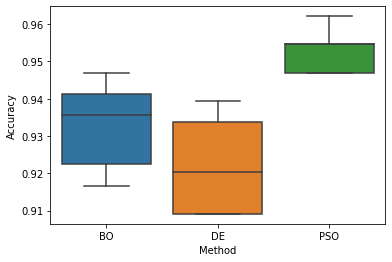

In [6]:
import seaborn as sns
sns.boxplot(x="Method", y="Accuracy", data=data2)

In [7]:
pip install -U statsmodels

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install bioinfokit

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [9]:
# get ANOVA table as R like output
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Ordinary Least Squares (OLS) model
model = ols('Accuracy ~ C(Method)', data=data2).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(Method),0.003793,2.0,15.814815,0.000065
Residual,0.002518,21.0,NaN,NaN


In [10]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=data2['Accuracy'],
                          groups=data2['Method'],
                          alpha=0.05)

In [11]:
print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
    BO     DE  -0.0104 0.1627 -0.0242 0.0034  False
    BO    PSO   0.0199 0.0043  0.0061 0.0337   True
    DE    PSO   0.0303    0.0  0.0165 0.0441   True
---------------------------------------------------


# Descriptive statistics for Accuracy

In [12]:
BO = data2[data2['Method'] == 'BO']
PSO = data2[data2['Method'] == 'PSO']
DE = data2[data2['Method'] == 'DE']
#summary of accuracy for Bayesian Optimisation
BO.Accuracy.describe()

count    8.000000
mean     0.932765
std      0.012440
min      0.916667
25%      0.922348
50%      0.935606
75%      0.941288
max      0.946970
Name: Accuracy, dtype: float64

In [13]:
#summary of accuracy for Differential Evolution
DE.Accuracy.describe()

count    8.000000
mean     0.922348
std      0.013277
min      0.909091
25%      0.909091
50%      0.920455
75%      0.933712
max      0.939394
Name: Accuracy, dtype: float64

In [14]:
#summary of accuracy for Particle Swam Optimisation
PSO.Accuracy.describe()

count    8.000000
mean     0.952652
std      0.005357
min      0.946970
25%      0.946970
50%      0.954545
75%      0.954545
max      0.962121
Name: Accuracy, dtype: float64